# Realization of Recursive Filters

*This jupyter/Python notebook is part of a [collection of notebooks](../index.ipynb) in the masters module [Digital Signal Processing](http://www.int.uni-rostock.de/Digitale-Signalverarbeitung.48.0.html), Comunications Engineering, Universität Rostock. Please direct questions and suggestions to <mailto:Sascha.Spors@uni-rostock.de>.*

## Quantization of Variables and Operations

As for [non-recursive filters](../nonrecursive_filters/quantization_effects.ipynb#Quantization-Effects), the practical realization of recursive filters may suffer from the quantization of variables and algebraic operations. The effects of [coefficient quantization](quantization_of_coefficients.ipynb) were already discussed. This section takes a look at the quantization of variables.  We limit the investigations to the recursive part of a second-order section (SOS), since any recursive filter of order $N \geq 2$ can be [decomposed into SOSs](cascaded_structures.ipynb).

The computation of the output signal $y[k] = \mathcal{H}\{ x[k] \}$ by a difference equation involves a number of multiplications and additions. As discussed already for [non-recursive filters](../nonrecursive_filters/quantization_effects.ipynb#Quantization-of-Signals-and-Operations), multiplying two numbers in a binary representation (e.g. [two's complement](https://en.wikipedia.org/wiki/Two's_complement) or [floating point](https://en.wikipedia.org/wiki/Floating_point)) requires requantization of the result to keep the word length constant. The addition of two numbers may fall outside the maximum/minimum values of the representation and may suffer from clipping.

The resulting round-off and clipping errors depend on the number and sequence of algebraic operations. These depend on the structure used for implementation of the SOSs. For ease of illustration we limit our discussion to the [direct form I and II](direct_forms.ipynb). Similar insights can be achieved in a similar manner for other structures.

### Analysis of Round-Off Errors

Round-off errors are a consequence of reducing the word length after a multiplication. In order to investigate the influence of these errors on a recursive filter, the statistical model for [round-off errors in multipliers](../nonrecursive_filters/quantization_effects.ipynb#Model-for-round-off-errors-in-multipliers) as introduced for non-recursive filters is used. We furthermore neglect clipping. 

The difference equation for the recursive part of a SOS realized in direct form I or II is given as

$$ y[k] =  x[k] - a_1 \, y[k-1] - a_2 \, y[k-2] $$

where $a_0 = 1$, $a_1$ and $a_2$ denote the coefficients of the recursive part. Introducing the requantization after the multipliers into the difference equation yields the output signal $y_Q[k]$

$$ y_Q[k] = x[k] - \mathcal{Q} \{ a_{1} \, y[k-1] \} - \mathcal{Q} \{ a_{2} \, y[k-2] \} $$

where $\mathcal{Q} \{ \cdot \}$ denotes the requantizer. Requantization is a non-linear process which results in a requantization error. If the value to be requantized is much larger that the quantization step $Q$, the average statistical properties of this error can be modeled as additive uncorrelated white noise. Introducing the error into above difference equation gives

$$ y_Q[k] = x[k] - a_1 \, y[k-1] - e_1[k] - a_2 \, y[k-2] - e_2[k] $$

where the two white noise sources $e_1[k]$ and $e_2[k]$ are assumed to be uncorrelated to each other. This difference equation can be split into a set of two difference equations

\begin{align}
y_Q[k] &= y[k] + e[k] \\
y[k] &=  x[k] - a_1 \, y[k-1] - a_2 \, y[k-2] \\
e[k] &= - e_1[k] - e_2[k] - a_1 \, e[k-1] - a_2 \, e[k-2]
\end{align}

The first difference equation computes the desired output signal $y[k]$ as a result of the input signal $x[k]$. The second one the additive error $e[k]$ due to requantization as a result of the requantization error $- (e_1[k] + e_2[k])$ injected into the recursive filter.
The power spectral density (PSD) $\Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega})$ of the error $e[k]$ is then given as

$$ \Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) = | H(\mathrm{e}^{\,\mathrm{j}\,\Omega})|^2 \cdot (\Phi_{e_1 e_1}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) + \Phi_{e_2 e_2}(\mathrm{e}^{\,\mathrm{j}\,\Omega})) $$

According to the model for the requantization errors, their PSDs are given as $\Phi_{e_1 e_1}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) = \Phi_{e_2 e_2}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) = \frac{Q^2}{12}$. Introducing this together with the transfer function of the SOS yields

$$ \Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) = \left| \frac{1}{1 + a_1 \, \mathrm{e}^{\,-\mathrm{j}\,\Omega} + a_2 \, \mathrm{e}^{\,-\mathrm{j}\,2\,\Omega}} \right|^2 \cdot \frac{Q^2}{6} $$





#### Example

The following example evaluates the error $e[k] = y_Q[k] - y[k]$ for a SOS which only consists of a recursive part. The desired system response $y[k]$ is computed numerically by floating point operations with double precision, $y_Q[k]$ is computed by applying a uniform midtread quantizer after the multiplications. The system is excited by uniformly distributed white noise. Besides the PSD $\Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega})$, the signal-to-noise ratio (SNR) $10 \cdot \log_{10} \left( \frac{\sigma_y^2}{\sigma_e^2} \right)$ in dB of the filter is evaluated.

SNR due to requantization: 44.778398 dB


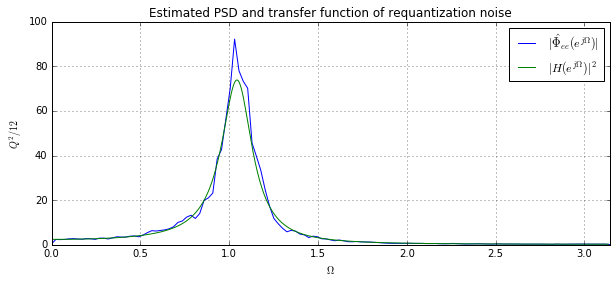

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig


N = 8192  # length of signals
w = 8  # wordlength for requantization of multiplications

def uniform_midtread_quantizer(x):
    # linear uniform quantization
    xQ = Q * np.floor(x/Q + 1/2)
    
    return xQ


def no_quantizer(x):
    
    return x


def sos_df1(x, a, requantize=None):
    y = np.zeros(len(x)+2)  # initial value appended
    for k in range(len(x)):
        y[k] = x[k] - requantize(a[1]*y[k-1])  - requantize(a[2]*y[k-2])
        
    return y[0:-2]


# cofficients of SOS
p = 0.90*np.array([np.exp(1j*np.pi/3), np.exp(-1j*np.pi/3)])
a = np.poly(p)
# quantization step
Q = 1/(2**(w-1))

# compute input signal
x = np.random.uniform(low=-1, high=1, size=N)
# compute output signals w and w/o requantization
yQ = sos_df1(x, a, requantize=uniform_midtread_quantizer)
y = sos_df1(x, a, requantize=no_quantizer)
# compute requantization error
e = yQ-y
# Signal-to-noise ratio
SNR = 10*np.log10(np.var(y)/np.var(e))
print('SNR due to requantization: %f dB'%SNR)

# estimate PSD of requantization error
nf, Pxx = sig.welch(e, window='hamming', nperseg=256, noverlap=128)
Pxx = .5*Pxx  # due to normalization in scipy.signal
Om = 2*np.pi*nf
# compute frequency response of system
w, H = sig.freqz([1,0,0], a)


# plot results
plt.figure(figsize=(10,4))
plt.plot(Om, Pxx/Q**2 * 12, 'b', label=r'$|\hat{\Phi}_{ee}(e^{j \Omega})|$')
plt.plot(w, np.abs(H)**2 * 2, 'g', label=r'$|H(e^{j \Omega})|^2$')
plt.title('Estimated PSD and transfer function of requantization noise')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$Q^2/12$')
plt.axis([0, np.pi, 0, 100])
plt.legend()
plt.grid();

### Small Limit Cycles

Besides the requantization noise, recursive filters may be subject to periodic oscillations present at the output. These undesired oscillations are termed *limit cycles*. Small limit cycles emerge from the additive round-off noise due to requantization after a multiplication. The feedback in a recursive filter leads to a feedback of the requantization noise. This may lead to a periodic output signal with an amplitude range of some quantization steps $Q$, even after the input signal is zero. The presence, amplitude and frequency of small limit cycles depends on the location of poles and the structure of the filter. A detailed treatment of this phenomenon is beyond the scope of this notebook and can be found in the literature.

#### Example

The following example illustrates small limit cycles for the system investigated in the previous example. The input signal is uniformly distributed white noise till time-index $k=256$ and zero for the remainder.

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


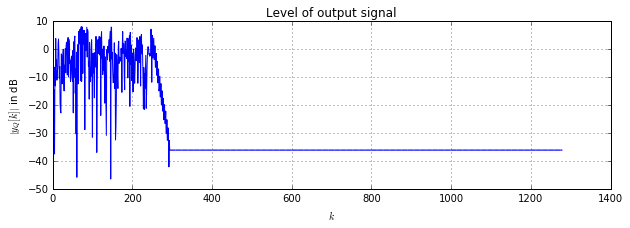

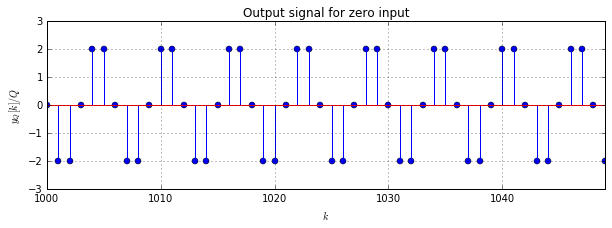

In [2]:
# compute input signal
x = np.random.uniform(low=-1, high=1, size=256)
x = np.concatenate((x, np.zeros(1024)))
# compute output signal
yQ = sos_df1(x, a, requantize=uniform_midtread_quantizer)

# plot results
plt.figure(figsize=(10, 3))
plt.plot(20*np.log10(np.abs(yQ)))
plt.title('Level of output signal')
plt.xlabel(r'$k$')
plt.ylabel(r'$|y_Q[k]|$ in dB')
plt.grid()

plt.figure(figsize=(10, 3))
k = np.arange(1000, 1050)
plt.stem(k, yQ[k]/Q)
plt.title('Output signal for zero input')
plt.xlabel(r'$k$')
plt.ylabel(r'$y_Q[k] / Q$ ')
plt.axis([k[0], k[-1], -3, 3])
plt.grid();

**Exercise**

* Estimate the period of the small limit cycles. How is it related to the poles of the system?
* What amplitude range is spanned?

### Large Limit Cycles

Large limit cycles are periodic oscillations of a recursive filter due to overflows in the multiplications/additions. As for small limit cycles, large limit cycles may be present even after the input signal is zero. Their level is typically in the range of the minimum/maximum value of the requantizer. Large limit cycles should therefore be avoided in a practical implementation. The presence of large limit cycles depends on the scaling of input signal and coefficients, as well as the strategy used to cope for clipping. Amongst others, they can be avoided by proper scaling of the coefficients to prevent overflow. Again, a detailed treatment of this phenomenon is beyond the scope of this notebook and can be found in the literature.

#### Example

The following example illustrates large limit cycles for the system investigated in the first example. In order to trigger large limit cycles, the coefficients of the filter have been doubled. The input signal is uniformly distributed white noise till time-index $k=256$ and zero for the remainder.

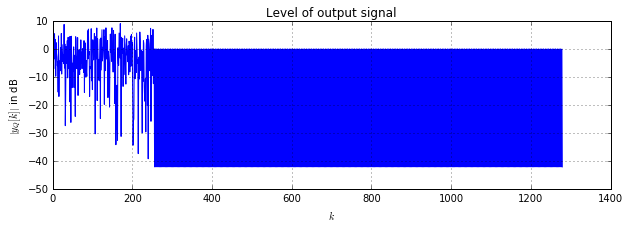

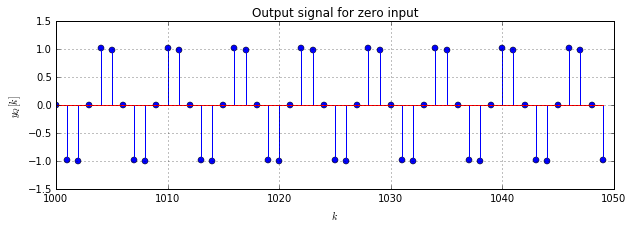

In [3]:
def uniform_midtread_quantizer(x, xmin=1):
    # limiter
    x = np.copy(x)
    if x <= -xmin:
        x = -1
    if x > xmin - Q:
        x = 1 - Q
    # linear uniform quantization
    xQ = Q * np.floor(x/Q + 1/2)
    
    return xQ


# compute input signal
x = np.random.uniform(low=-1, high=1, size=256)
x = np.concatenate((x, np.zeros(1024)))
# compute output signal
yQ = sos_df1(x, 2*a, requantize=uniform_midtread_quantizer)

# plot results
plt.figure(figsize=(10, 3))
plt.plot(20*np.log10(np.abs(yQ)))
plt.title('Level of output signal')
plt.xlabel(r'$k$')
plt.ylabel(r'$|y_Q[k]|$ in dB')
plt.grid()

plt.figure(figsize=(10, 3))
k = np.arange(1000, 1050)
plt.stem(k, yQ[k])
plt.title('Output signal for zero input')
plt.xlabel(r'$k$')
plt.ylabel(r'$y_Q[k]$ ')
#plt.axis([k[0], k[-1], -1.1, 1.1])
plt.grid();

**Exercise**

* Determine the period of the large limit cycles. How is it related to the poles of the system?

**Copyright**

<p xmlns:dct="http://purl.org/dc/terms/">
  <a rel="license"
     href="http://creativecommons.org/publicdomain/zero/1.0/">
    <img src="http://i.creativecommons.org/p/zero/1.0/88x31.png" style="border-style: none;" alt="CC0" />
  </a>
  <br />
  To the extent possible under law,
  <span rel="dct:publisher" resource="[_:publisher]">the person who associated CC0</span>
  with this work has waived all copyright and related or neighboring
  rights to this work.
</p>